In [1]:
#Create Access to my code
import sys
sys.path.insert(1, '../models/')

#Import hte vaedr functions we have created
from hvit import HVIT

#Import manifold
sys.path.insert(1, '../manifolds/')
from poincareball import PoincareBall

#Import important modules
import scanpy as sc
import scgen as scg
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy import stats
from scipy import linalg
from scipy import spatial
from anndata import AnnData
from scipy import sparse
from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt

import scvi

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
#Prepare Data Set
doses = [0, 30]
adata_dict = {}
for d in doses:
    adata = sc.read_h5ad("../../../../data/sc_tcdd_liver_dose_"+str(d)+".h5ad")
    adata_dict[str(d)] = adata

adata = adata_dict['0'].concatenate([adata_dict[str(key)] for key in [30]])

dose_ids = {doses[i]:"-"+str(i) for i in range(2)}

meta = pd.read_csv("../../../../data/dose-response.metadata.txt", sep = '\t')
meta = meta[(meta["Dose"] == 0) | (meta["Dose"] == 30)]
meta.index = np.concatenate([[i+dose_ids[d] for i in meta[meta['Dose']==d].index]  for d in doses])

adata.obs["celltype"] = meta["new.cell.type"]
adata.obs_names
cell_types_of_int = ["Hepatocytes - central", "Hepatocytes - portal", "Cholangiocytes", "Stellate Cells", "Portal Fibroblasts", "Endothelial Cells"]
adata = adata[adata.obs['celltype'].isin(cell_types_of_int)]

adata.obs["dose"] = [str(i) for i in adata.obs["Dose"]]

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

adata = adata[:,adata.var.highly_variable]

Trying to set attribute `.obs` of view, copying.


In [3]:
train_adata = adata
train_adata = scvi.data.setup_anndata(train_adata, copy = True, batch_key = "Dose", labels_key="celltype")

INFO     Using batches from adata.obs["Dose"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18865 cells, 2557 vars, 2 batches,
         6 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [19]:
latent_dim = 2

In [20]:
manifold = PoincareBall(dim =latent_dim)

In [21]:
model = HVIT(manifold,train_adata,n_hidden_layers = 3,latent_dim = latent_dim, kl_weight = 5e-5, linear_decoder = False)

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [22]:
model.module.kl_weight

5e-05

In [23]:
model.module.latent_dim

2

In [24]:
model.train(max_epochs=250,
    batch_size=128,
    early_stopping=True,
    early_stopping_patience=25)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Set SLURM handle signals.


Epoch 31/250:  12%|█▏        | 31/250 [03:48<26:55,  7.38s/it, loss=94.5, v_num=1]


In [25]:
latent_X = model.get_latent_representation()
# latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
# cell_dose = [f"{j}_{str(i)}" for (i,j) in zip(adata.obs["Dose"], adata.obs["celltype"])]
# latent_adata.obs["Cell_Dose"] = cell_dose

/mnt/home/kanaomar/miniconda3/lib/python3.9/site-packages/scvi/model/base/_base_model.py:147: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [28]:
x = latent_X[:, 0]
y = latent_X[:, 1]
z = np.sqrt(1 + np.sum(latent_X**2, axis=1))

In [29]:
disk_x = x / (1 + z)
disk_y = y / (1 + z)

<AxesSubplot:xlabel='x', ylabel='y'>

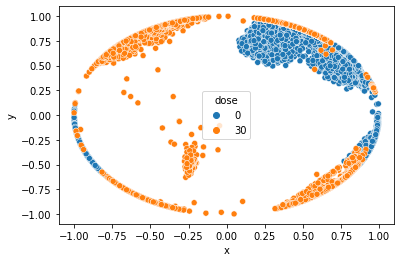

In [31]:
df = pd.DataFrame({"x":latent_X[:,0], "y":latent_X[:, 1], "celltype":adata.obs["celltype"].values, "dose":adata.obs["dose"].values})
sns.scatterplot(x = "x", y = "y", hue = "dose", data = df)

<AxesSubplot:xlabel='x', ylabel='y'>

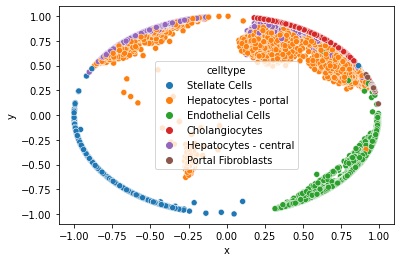

In [32]:
sns.scatterplot(x = "x", y = "y", hue = "celltype", data = df)

In [11]:
# sc.pp.neighbors(latent_adata)

In [12]:
# from umap import UMAP

In [13]:
# hyperbolic_mapper = UMAP(output_metric='hyperboloid',
#                               random_state=42).fit(latent_X)

In [14]:
x = latent_X[:, 0]
y = latent_X[:, 1]
z = np.sqrt(1 + np.sum(latent_X**2, axis=1))

In [15]:
disk_x = x / (1 + z)
disk_y = y / (1 + z)

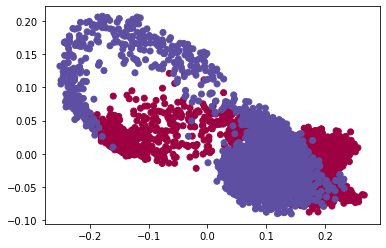

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y, c=adata.obs.Dose, cmap='Spectral')
boundary = plt.Circle((0,0), 1, fc='none', ec='k')
ax.add_artist(boundary)
plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

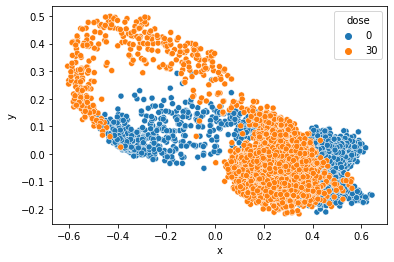

In [17]:
df = pd.DataFrame({"x":latent_X[:,0], "y":latent_X[:, 1], "celltype":adata.obs["celltype"].values, "dose":adata.obs["dose"].values})
sns.scatterplot(x = "x", y = "y", hue = "dose", data = df)

<AxesSubplot:xlabel='x', ylabel='y'>

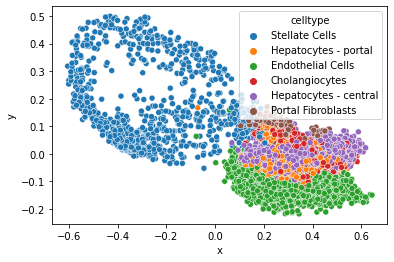

In [18]:
sns.scatterplot(x = "x", y = "y", hue = "celltype", data = df)